In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report 
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit,StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
test = pd.read_csv('poker-hand-testing.data')
train = pd.read_csv('poker-hand-training-true.data')

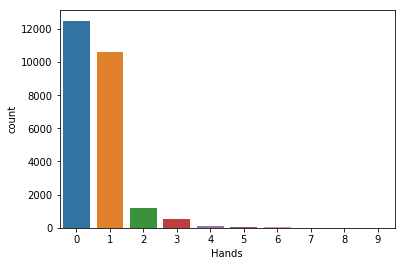

In [3]:
#From the count plot we can see that there is a really big class imbalance in the training data set.
#In order to deal with this, a stratifiedshuffle split will be used on our dataset to ensure that 
#at least some of the samples make it into both the training and validation sets.
sns.countplot('9',data=train)
plt.xlabel('Hands')
plt.show()

In [32]:
y = train['9']
X = train.drop('9',axis=1)
folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

In [33]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train.shape[0], 10))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [34]:
# params = {'colsample_bytree': (0.6, 0.8),
#       'learning_rate': (.0001, .5), 
#       'num_leaves': (2, 124), 
#       'subsample': (0.6, 1), 
#       'max_depth': (3, 120), 
#       'reg_alpha': (.001, 15.0), 
#       'reg_lambda': (.001, 15.0), 
#       'min_split_gain': (.001, .03),
#       'min_child_weight': (2, 80)}

# bo = BayesianOptimization(lgbm_evaluate, params)
# bo.maximize(init_points=5, n_iter=10)

In [35]:
# params = bo.max['params']
# params['num_leaves'] = 4
# params['max_depth'] =5
# test_pred_proba = np.zeros((train.shape[0], 10))
# folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
#         model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
#         model.fit(X_train, y_train, 
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
#                 verbose=False, early_stopping_rounds=200)

#         y_pred_valid = model.predict_proba(X_valid)

#         test_pred_proba[valid_idx] = y_pred_valid

#         print(accuracy_score(y_valid, y_pred_valid.argmax(1)))

In [36]:
# y = test['0']
# X = test.drop('0',axis=1)
# test_pred_proba = np.zeros((test.shape[0], 10))
# y_pred_valid = model.predict_proba(X)
# #test_pred_proba[valid_idx] = y_pred_valid
# print(accuracy_score(y, y_pred_valid.argmax(1)))

In [37]:
# cm = confusion_matrix(y,y_pred_valid.argmax(1))
# df_cm = pd.DataFrame(cm)
# plt.figure(figsize = (15,10))
# sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')

In [38]:
# After Bayesian Optimization, the this lightGBM model could only predict ~65.5% accuracy
#This could be because random forest struggles with fitting models that have 
#high class imbalances 

In [39]:
X_train = torch.from_numpy(X.values.astype(np.float32))
y = torch.from_numpy(y.values)

In [44]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size3,num_classes)
        self.sigmoid = nn.Sigmoid()
        #self.softmax1 = nn.Softmax()
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        out = self.sigmoid(out)
        #out = self.softmax1(out)
        return out

In [88]:
weights = torch.Tensor(1/(train['9'].value_counts()/len(train)))
model = NeuralNet(10,50,50,50,10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(weights))

In [89]:

for epoch in range(500):
    # Forward Propagation
    y_pred = model(X_train)
    # Compute and print loss
    loss = criterion(y_pred, y)
    if epoch %10 == 0:
        print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  2.3061163425445557
epoch:  10  loss:  2.2658588886260986
epoch:  20  loss:  2.2342562675476074
epoch:  30  loss:  2.2027528285980225
epoch:  40  loss:  2.18245267868042
epoch:  50  loss:  2.155003070831299
epoch:  60  loss:  2.1302554607391357
epoch:  70  loss:  2.1091997623443604
epoch:  80  loss:  2.0885026454925537
epoch:  90  loss:  2.0762670040130615
epoch:  100  loss:  2.0672852993011475
epoch:  110  loss:  2.030315399169922
epoch:  120  loss:  2.0333240032196045
epoch:  130  loss:  2.019164800643921
epoch:  140  loss:  2.0085742473602295
epoch:  150  loss:  1.986789345741272
epoch:  160  loss:  2.0354533195495605
epoch:  170  loss:  1.9649807214736938
epoch:  180  loss:  1.9957085847854614
epoch:  190  loss:  1.9863743782043457
epoch:  200  loss:  1.9437044858932495
epoch:  210  loss:  1.9431495666503906
epoch:  220  loss:  1.9394742250442505
epoch:  230  loss:  1.943398356437683
epoch:  240  loss:  1.9324588775634766
epoch:  250  loss:  1.9206898212432861
epoc

In [90]:
X_test = torch.from_numpy(test.drop('0',axis=1).values.astype(np.float32))
y_test = torch.from_numpy(test['0'].values)

In [91]:
y_pred = model(X_test)
y_pred = pd.Series(torch.max(y_pred,1)[1].numpy())

In [92]:
print(classification_report(y_test,y_pred,labels = y.unique()))

              precision    recall  f1-score   support

           0       0.56      0.27      0.37    501208
           1       0.40      0.28      0.33    422498
           2       0.05      0.11      0.06     47622
           3       0.03      0.17      0.05     21121
           4       0.04      0.37      0.08      3885
           5       0.00      0.06      0.00      1996
           6       0.00      0.14      0.00      1424
           7       0.00      0.06      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.33      0.00         3

   micro avg       0.27      0.27      0.27    999999
   macro avg       0.11      0.18      0.09    999999
weighted avg       0.45      0.27      0.33    999999



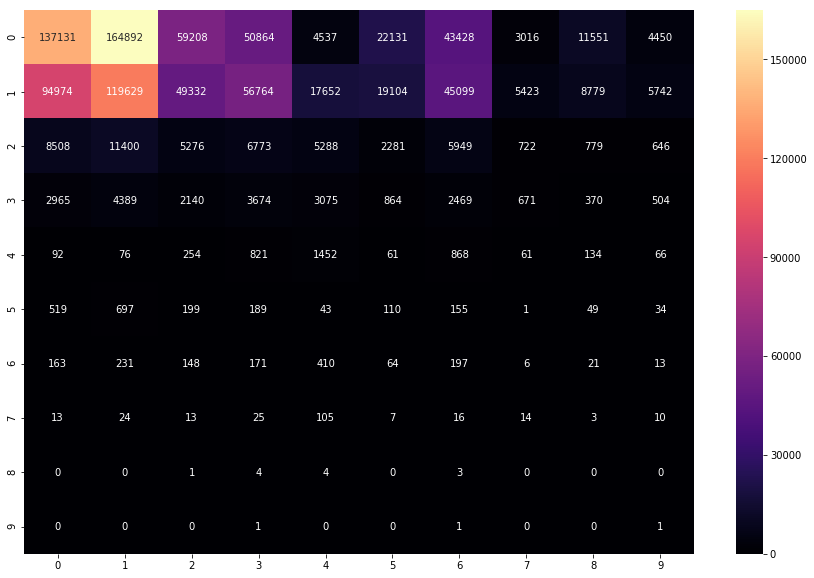

In [93]:
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')
plt.show()